<div style="background-color: #f0f0f0; padding: 10px;">
    <h3 style="color: #336699;">Generating New Drug SMILES Data Using Model RNN-LTSM</h3>
</div>

<div style="padding: 10px;">
<p>The goal of the task I'm working on is to generate new molecules using a Recurrent Neural Network. <strong>De novo simply means to synthesize new</strong>. The idea is to train the model to learn patterns in SMILES strings so that the output generated can match valid molecules. SMILES is a string representation of a molecule based on its structure and different components, making it a computer-friendly way to represent molecules.</p>

<strong>Steps:</strong>
1. <strong>Install Rdkit</strong>:
    Rdkit is a cheminformatics toolkit that enables working with chemical structures and data. To install it, you can use the following command:
    
    ```
    !pip install rdkit-pypi
    ```

2. <strong>Install DeepChem</strong>:
    DeepChem is a Python library that provides tools for deep learning in cheminformatics. You can install it using the following command:
    
    ```
    !pip install deepchem
    ```

3. <strong>Import Libraries</strong>:
    In your Jupyter Notebook, import the required libraries for working with Rdkit and DeepChem:
    
</div>


## import general packages to per-process data SMILES


first step : install Rdkit package to deal with Chemical data SMILES  
- loading dataset and convert to DATAFRAME using Rdkit.Panads.Tools
   and do some analysis on it

In [1]:
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()
# I HAVE ALREADY INSTALLED ON MY ENVIROMENET
!mamba install -c conda-forge rdkit

In [2]:
!curl -Lo deepchem_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py



curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0  30184      0 --:--:-- --:--:-- --:--:-- 30324


In [3]:
import deepchem_installer
deepchem_installer.install()

add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
all packages are already installed


In [4]:
%%capture
!pip install transformers
!pip install --pre deepchem

In [5]:
import deepchem
deepchem.__version__

No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


'2.7.2.dev'

In [6]:
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
import os
from rdkit import Chem
from rdkit import RDConfig
import numpy as np
from rdkit.Chem import Draw , Descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive , files
drive.mount('/drive')

Mounted at /drive


#### load Dataset and process:

* read the CSV file, and the delimiter is set to "\t" to handle tab-separated values. The columns are named "smiles" and "labels" using the `names` parameter. The resulting DataFrame is stored in the variable `data`. Finally, the `set_index` method is called to set the "smiles" column as the index of the DataFrame, but the `inplace` parameter is set to False, so the original DataFrame is not modified, and the result is displayed in the output of the code cell.


In [7]:
data_training ='/drive/My Drive/smiles'
smifile = data_training + '/training.smi'
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","labels"], index_col=False)
data.set_index("smiles",inplace=False)

,labels
smiles,
CC(N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23)c4ccccc4,0
CN(C1CCN(CC1)c2cc(ncn2)C(F)(F)F)C(=O)C3=CN(CC=C)C(=O)c4[nH]ccc34,0
CN1C(=O)C=Cc2ccccc12,0
CC(C)N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23,0
CC(=O)c1cc(c2ccccc2S(=O)(=O)C)c3ccccn13,0
...,...
COc1cc2N(C)C(=O)C=C(C)c2cc1NS(=O)(=O)c3ccc(cc3)C#N,1
CN1C(=O)C=Cc2cc(NS(=O)(=O)c3ccc(cc3)C#N)ccc12,1
CN1C(=O)C=Cc2cc(NS(=O)(=O)c3ccc(cc3)C#N)ccc12,1


In [8]:
data.head(10)

,smiles,labels
0,CC(N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23...,0
1,CN(C1CCN(CC1)c2cc(ncn2)C(F)(F)F)C(=O)C3=CN(CC=...,0
2,CN1C(=O)C=Cc2ccccc12,0
3,CC(C)N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23,0
4,CC(=O)c1cc(c2ccccc2S(=O)(=O)C)c3ccccn13,0
5,CC(=O)c1cc(c2ccccc2S(=O)(=O)C)c3cc(Oc4ccccc4)c...,0
6,CNC(=O)N1CCc2c(C1)c(nn2C3CCOCC3)N4CCCc5cc(c6cn...,0
7,CC(=O)N1CCc2[nH]nc(Nc3ccccc3)c2C1,0
8,CC(=O)N1CCc2c(C1)c(Nc3ccc(cc3F)c4cnn(C)c4)nn2[...,0
9,CN(C1CCN(C)CC1)C(=O)C2=CN(C)C(=O)c3[nH]ccc23,0


In [9]:
data.describe()

,labels
count,102.000000
mean,0.656863
std,0.477101
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
data.iloc[0:5]
data.iloc[:-4]

,smiles,labels
0,CC(N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23...,0
1,CN(C1CCN(CC1)c2cc(ncn2)C(F)(F)F)C(=O)C3=CN(CC=...,0
2,CN1C(=O)C=Cc2ccccc12,0
3,CC(C)N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23,0
4,CC(=O)c1cc(c2ccccc2S(=O)(=O)C)c3ccccn13,0
...,...,...
93,COc1ccc(cc1)S(=O)(=O)Nc2cc(ccc2N3CCN(C)CC3)c4n...,1
94,COc1cc(cc(C)c1CN(C)C)C2=CN(C)C(=O)C(=C2)C,1
95,C[C@@H]1CC(=O)Nc2cccc(c2N1)c3ccc4c(c3)c(nn4C)c...,1
96,C[C@@H]1CC(=O)Nc2cccc(c2N1)c3ccc4c(c3)c(nn4C)c...,1


In [11]:
data.smiles[0]

'CC(N1CCC(CC1)N(C)C(=O)C2=CN(C)C(=O)c3[nH]ccc23)c4ccccc4'

#### Virtualize Chemical Components:

* The function `mol_with_atom_index(mol)` that takes a molecule (`mol`) as input and sets the atom map numbers to the atom indices in the molecule. This is done to show the atom indices when drawing the molecule.

- Next, `IPythonConsole.drawOptions.addAtomIndices = True` is set to enable displaying the atom indices in the molecule visualization.

    1. The `size` variable is set to `300, 300`, which determines the size of the molecule visualization.

    2. A molecule (`mol_1`) is created using the SMILES representation of the third row in the `data` DataFrame (`data.smiles.iloc[2]`).

    3. The `mol_with_atom_index` function is called with `mol_1` as an argument, and the result is stored in the variable `mol_indexAtom`.

    4. The last line of the code cell will display the molecule visualization with atom indices.

In [12]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

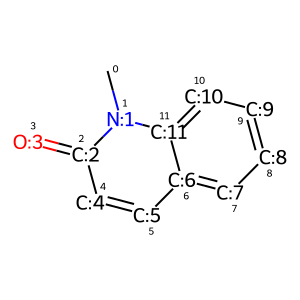

In [13]:
IPythonConsole.drawOptions.addAtomIndices = True
size=IPythonConsole.molSize = 300,300
mol_1=Chem.MolFromSmiles(data.smiles.iloc[2])
mol_indexAtom=mol_with_atom_index(mol_1)
mol_indexAtom

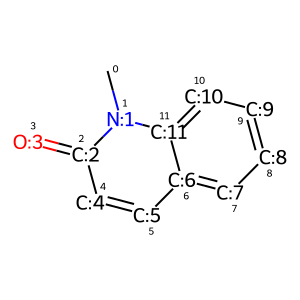

In [14]:
IPythonConsole.molSize = 300,300

mol_indexAtom

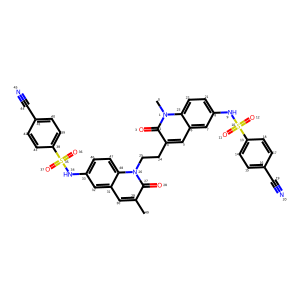

In [15]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
for i in range(5):
  j=0
  for j in iter(data.smiles):
    j+=j
  mol=Chem.MolFromSmiles(j)
  mol
mol

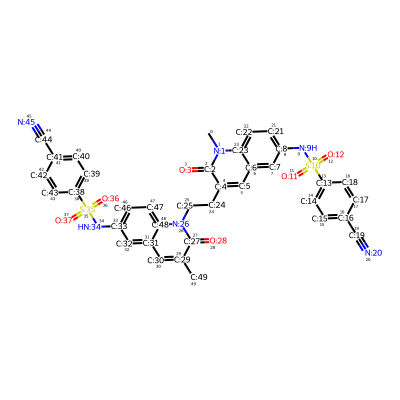

In [16]:
IPythonConsole.molSize = 400,400
mol_with_atom_index(mol)

#### transformations and feature engineering :

In this code cell, we perform transformations and feature engineering for a Chemical dataset input. The dataset contains SMILES representations of chemical compounds.

  1. We create a `charset` containing unique characters from all SMILES strings along with special characters ("!" for start and "E" for end).
  2. We create dictionaries `char_to_int` and `int_to_char` to map characters to integers and vice versa.
  3. The variable `embed` is set to the length of the longest SMILES string in the dataset plus 5, which determines the embedding size for one-hot encoding.

  4. The function `vectorize(smiles)` is defined to convert SMILES strings to one-hot encoded vectors. The function iterates through each SMILES string and encodes it as a one-hot vector. It adds special characters ("!" at the start and "E" at the end) to indicate the beginning and end of the sequence.

  5. The `vectorize` function is applied to the training and test datasets (`smiles_train` and `smiles_test`) to create input (`X_train` and `X_test`) and output (`Y_train` and `Y_test`) arrays for training and testing purposes.

  6. Information about the first SMILES string in the training dataset is displayed using `print(smiles_train.iloc[0])`.

  7. A visualization of the one-hot encoded representation of the first SMILES string in the training dataset is displayed using `plt.matshow(X_train[0].T)`.

In [17]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(76,)
(26,)


In [18]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'s', '!', '@', ']', 'C', 'S', '5', 'F', 'r', '1', ')', 'E', '=', 'H', '#', 'O', 'l', '4', '(', '3', '6', 'n', 'B', 'N', '[', 'c', '2'}
27 82


C[C@H]1C[C@@H](Nc2ccc(Cl)cc2)c3cc(ccc3N1C(=O)C)c4ccc(cc4)C(=O)O


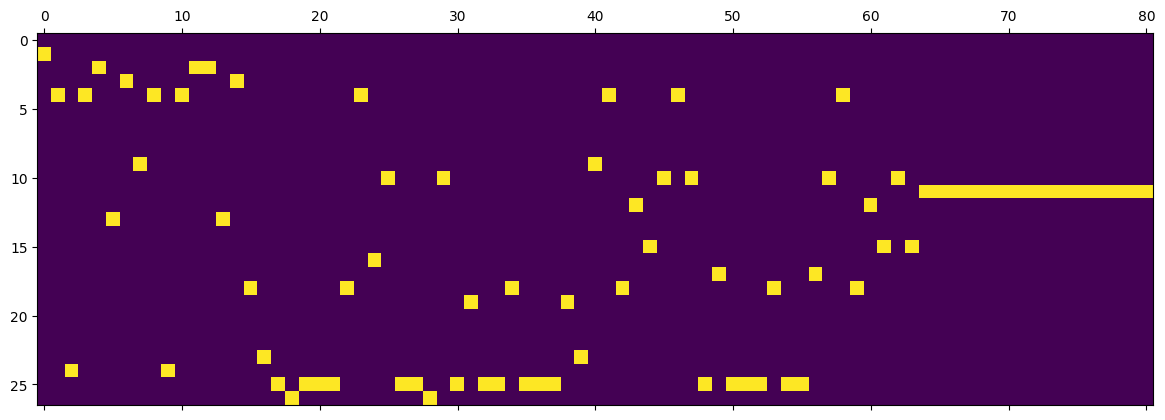

In [19]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [20]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!C[C@H]1C[C@@H](Nc2ccc(Cl)cc2)c3cc(ccc3N1C(=O)C)c4ccc(cc4)C(=O)OEEEEEEEEEEEEEEEEE'

In [21]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [22]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 81, 27)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         23552       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [23]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

In [24]:
from keras.optimizers import RMSprop, Adam
#opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h])

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 3.3220
Epoch 2/200
1/1 [==============================] - 0s 136ms/step - loss: 3.2955
Epoch 3/200
1/1 [==============================] - 0s 120ms/step - loss: 3.2697
Epoch 4/200
1/1 [==============================] - 0s 114ms/step - loss: 3.2442
Epoch 5/200
1/1 [==============================] - 0s 114ms/step - loss: 3.2187
Epoch 6/200
1/1 [==============================] - 0s 113ms/step - loss: 3.1930
Epoch 7/200
1/1 [==============================] - 0s 112ms/step - loss: 3.1668
Epoch 8/200
1/1 [==============================] - 0s 114ms/step - loss: 3.1397
Epoch 9/200
1/1 [==============================] - 0s 112ms/step - loss: 3.1115
Epoch 10/200
1/1 [==============================] - 0s 132ms/step - loss: 3.0817
Epoch 11/200
1/1 [==============================] - 0s 122ms/step - loss: 3.0499
Epoch 12/200
1/1 [==============================] - 0s 121ms/step - loss: 3.0155
Epoch 13/200
1/1 [======================

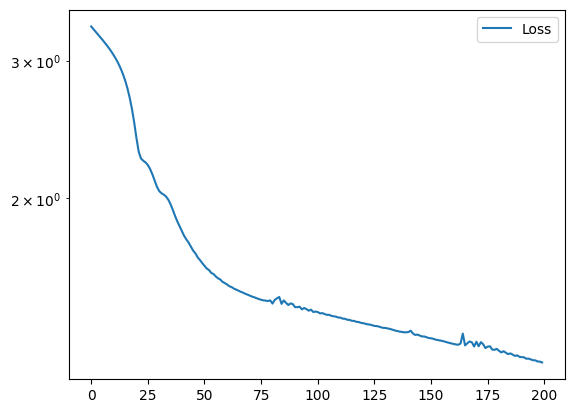

In [25]:
plt.plot(h.history["loss"], label="Loss")
#plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [26]:
for i in range(26):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
      print(true,pred)

1/1 [==============================] - 1s 1s/step
CN1CC[C@@H](Nc2ncc(c3C=C(C)C(=O)Nc23)c4cncc(C)c4)[C@@H](C1)OCC5CCS(=O)(=O)CC5EEE CCCCCCCCCCCCCCccccccccc))))C)C))CCccccccccccccccccCCEECECCCCCEEEEEEEEEE=))C))))E
1/1 [==============================] - 0s 57ms/step
CCN1C=C(c2cccc(c2)C(F)(F)F)c3sc(cc3C1=O)C(=N)NC4CCS(=O)(=O)CC4EEEEEEEEEEEEEEEEEE CCCCCCCCCcccccccccc)))CC)c)cccccccccc)))CCCCCCCCCCC(CO)(=O)cEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 45ms/step
CN1C=C(c2cccc(c2)C#N)c3sc(cc3C1=O)C(=N)NC4CCS(=O)(=O)CC4EEEEEEEEEEEEEEEEEEEEEEEE CCCCCCCCcccccccccc)c)Cccccccccc)))CCCCCCCCCCC(CC)C=O)c)EEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 55ms/step
COc1cc(ccc1S(=O)(=O)Nc2ccc3N(C)C(=O)C(=Cc3c2)C)C#NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CCCccccccccccC))CC))c)cccccccCCCCCC)CCCC)cccccCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 53ms/step
CC(C)CS(=O)(=O)N[C@H]1CCC(=O)N([C@@H]1c2ccc(Cl)cc2)c3ccc4C(=CC(=O)N(C)c4c3)CEEEE CCCCCcC(CCCcc

In [27]:
data_training ='/drive/My Drive/smiles'
smifile = data_training + '/Results.txt'
data = pd.read_csv(smifile, delimiter = "\t", index_col=False)
data.head()

,Real_Smlies predicted_Smlies
0,CN1CC[C@@H](Nc2ncc(c3C=C(C)C(=O)Nc23)c4cncc(C)...
1,CCN1C=C(c2cccc(c2)C(F)(F)F)c3sc(cc3C1=O)C(=N)N...
2,CN1C=C(c2cccc(c2)C#N)c3sc(cc3C1=O)C(=N)NC4CCS(...
3,COc1cc(ccc1S(=O)(=O)Nc2ccc3N(C)C(=O)C(=Cc3c2)C...
4,CC(C)CS(=O)(=O)N[C@H]1CCC(=O)N([C@@H]1c2ccc(Cl...
